# Testing bias metrics and mitigation algorithms on the Compas dataset

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from utility import *
from Sampler import Sampler
sns.set_theme(style='darkgrid')

## Dataset Description

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [5]:
compas = CompasDataset(features_to_drop=['age_cat'])

In [6]:
compas.protected_attribute_names

['sex', 'race']

In [7]:
compas.metadata['protected_attribute_maps']

[{0.0: 'Male', 1.0: 'Female'}, {1.0: 'Caucasian', 0.0: 'Not Caucasian'}]

In [8]:
compas.label_names

['two_year_recid']

In [9]:
compas.favorable_label

0.0

In [10]:
compas_df = compas.convert_to_dataframe()[0]

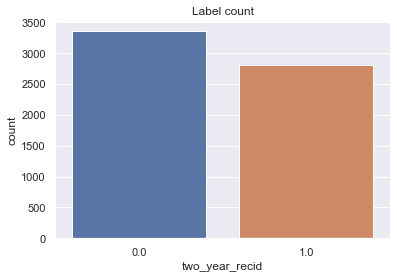

In [11]:
sns.countplot(x='two_year_recid', data=compas_df)
plt.title("Label count")
plt.show()

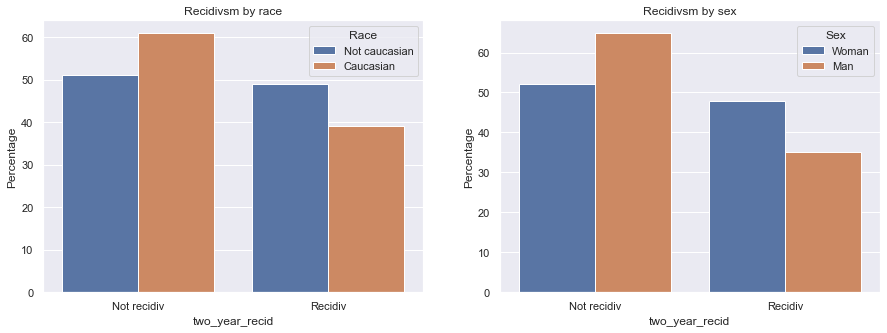

In [12]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(15,5))
score_group = (compas_df.groupby(['race'])['two_year_recid']
              .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
score_group_sex = (compas_df.groupby(['sex'])['two_year_recid']
              .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
sns.barplot(data=score_group_sex, x='two_year_recid', y='Percentage', hue='sex', ax=ax2)
ax2.set_xticklabels({'Not recidiv', 'Recidiv'})
leg = ax2.legend()
leg.set_title('Sex')
leg.get_texts()[0].set_text('Woman')
leg.get_texts()[1].set_text('Man')
ax2.set_title('Recidivsm by sex')
sns.barplot(data=score_group, x='two_year_recid', y='Percentage', hue='race', ax=ax1)
ax1.set_xticklabels({'Not recidiv', 'Recidiv'})
leg = ax1.legend()
leg.set_title('Race')
leg.get_texts()[0].set_text('Not caucasian')
leg.get_texts()[1].set_text('Caucasian')
ax1.set_title('Recidivsm by race')
plt.show()

So we are in a **Balanced bias dataset** case

# Bias dataset and classification metrics

In [13]:
privileged_group = [{'sex':1, 'race':1}]
unprivileged_group = [{'sex':0, 'race':0}]

## Bias dataset case

### Dataset Metrics:

Disparate Impact: 0.7481
Statistical Parity: -0.1628




### Classification Metrics:

Balanced accuracy: 0.6617
Statistical parity difference: -0.3976
Disparate impact: 0.5188
Average odds difference: -0.3742
Equal opportunity difference: -0.2960
Theil index: 0.2336


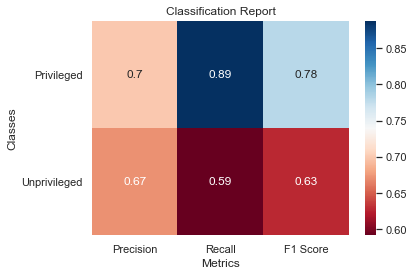

In [14]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    compas, privileged_group, unprivileged_group)

## Reweighing

In [15]:
rw_data = compas.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.6561
Statistical parity difference: -0.1346
Disparate impact: 0.8118
Average odds difference: -0.0860
Equal opportunity difference: -0.0644
Theil index: 0.2066


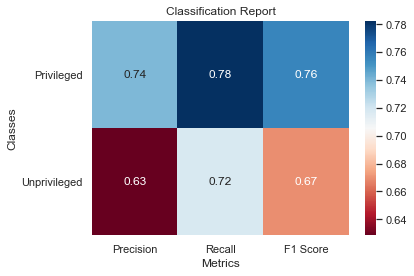

In [19]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_data, privileged_group, unprivileged_group, debiaser=rw)

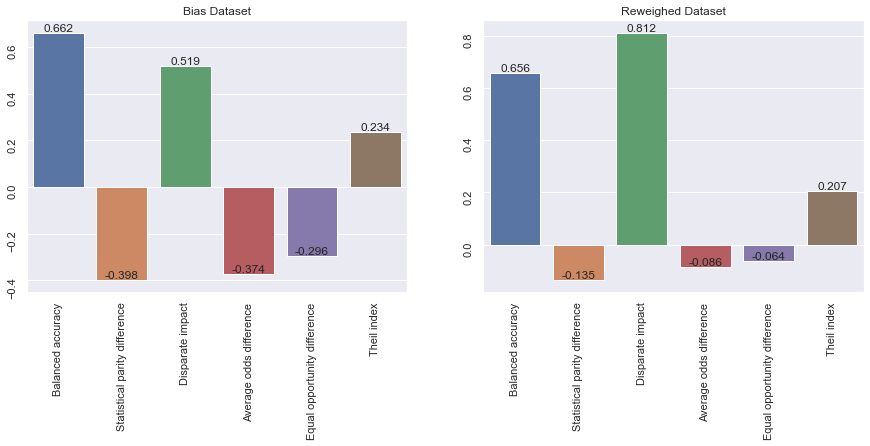

In [28]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact

Since we have two sensitive attributes, DIR requires to create an attribute that is the joint probability distribution of the two sensitive attributes and to transform the unsensitive variables with respect to this new variable:

In [30]:
dir_data = compas.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [31]:
df = dir_data.convert_to_dataframe()[0]
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

In [32]:
for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

In [33]:
df.drop(df[['sex','race']], axis=1, inplace=True)

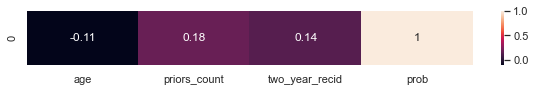

In [34]:
corr = df.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [35]:
probs

,sex,race,probs
0,0.0,0.0,0.547106
1,1.0,0.0,0.112372
2,0.0,1.0,0.262689
3,1.0,1.0,0.077834


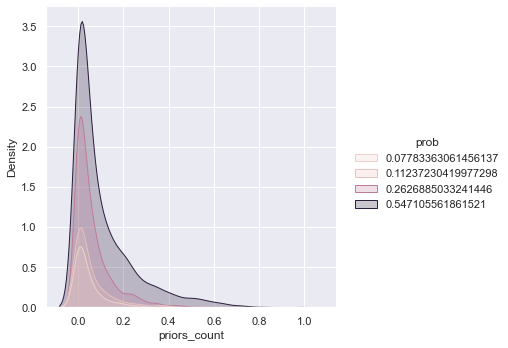

In [36]:
sns.displot(data=df, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

In [37]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df=df, label_names=['two_year_recid'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


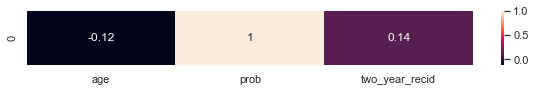

In [38]:
df_dir = dir_data.convert_to_dataframe()[0]
corr = df_dir.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [39]:
df.loc[df['prob'].round(6) == 0.077834, 'prob'] = 1
df.loc[df['prob'].round(6) != 1, 'prob'] = 0

df_dir.loc[df_dir['prob'].round(6) == 0.077834, 'prob'] = 1
df_dir.loc[df_dir['prob'].round(6) != 1, 'prob'] = 0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


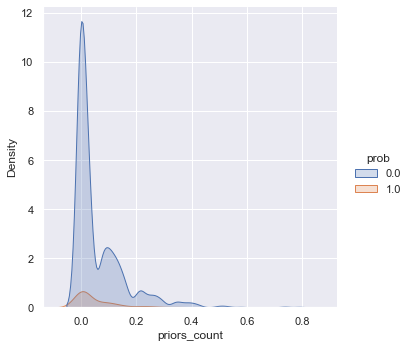

In [40]:
sns.displot(data=df_dir, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

In [41]:
prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir_data = BinaryLabelDataset(df=df_dir, label_names=['two_year_recid'], protected_attribute_names=['prob'])

### Dataset Metrics:

Disparate Impact: 1.3104
Statistical Parity: 0.1099




### Classification Metrics:

Balanced accuracy: 0.6606
Statistical parity difference: 0.1046
Disparate impact: 1.3304
Average odds difference: 0.0693
Equal opportunity difference: 0.0593
Theil index: 0.2246


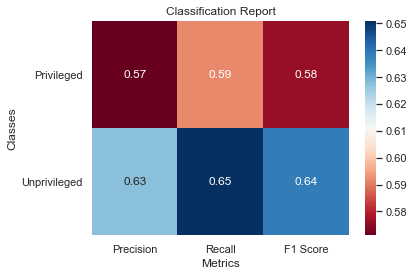

In [42]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, priv_group = prob_priv_group, unpriv_group = prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


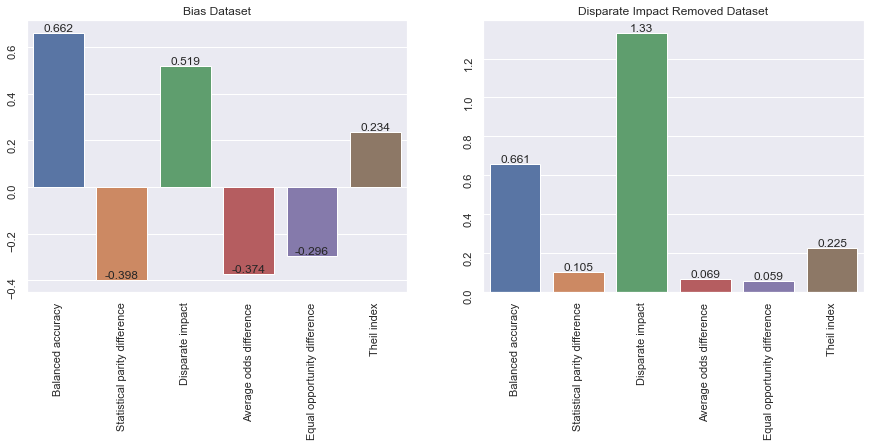

In [43]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

In [44]:
sampled_data = compas.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 1.0078
Statistical Parity: 0.0036




### Classification Metrics:

Balanced accuracy: 0.6549
Statistical parity difference: -0.0175
Disparate impact: 0.9712
Average odds difference: 0.0265
Equal opportunity difference: 0.0467
Theil index: 0.2416


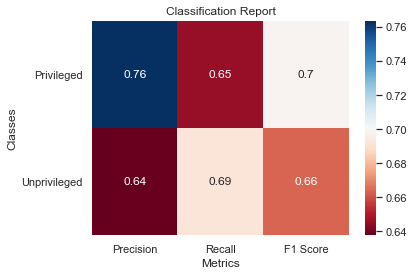

In [45]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


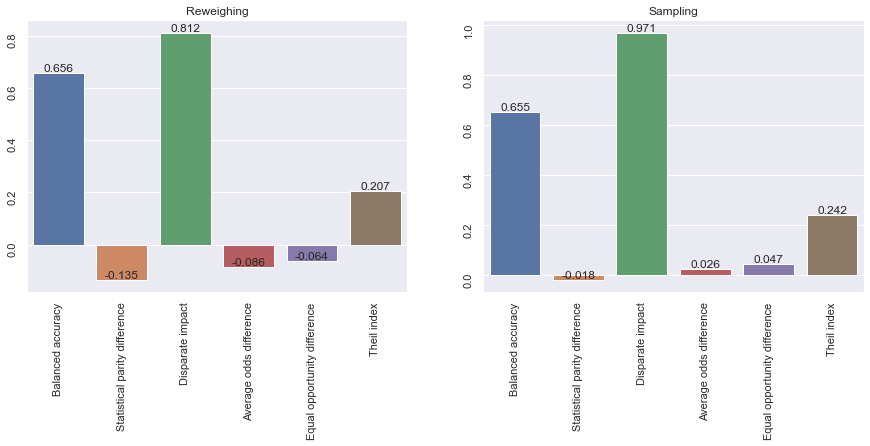

In [46]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

## Reweighing + DIR

In [47]:
rw_dir_data = dir_data.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

In [48]:
rw_dir_data = rw.fit_transform(rw_dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


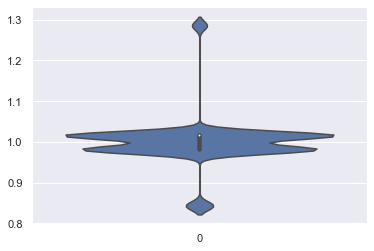

In [49]:
sns.violinplot(data= rw_dir_data.instance_weights)
plt.show()

### Dataset Metrics:

Disparate Impact: 1.0004
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.6636
Statistical parity difference: 0.0716
Disparate impact: 1.2121
Average odds difference: 0.0712
Equal opportunity difference: 0.0574
Theil index: 0.2239


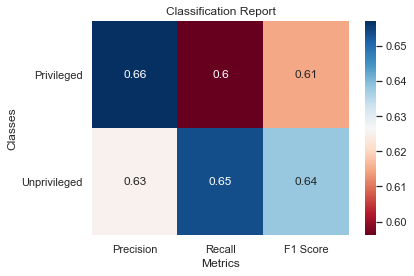

In [50]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_data, priv_group=prob_priv_group, unpriv_group=prob_unpriv_group, sensitive_attributes=rw_dir_data.protected_attribute_names)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


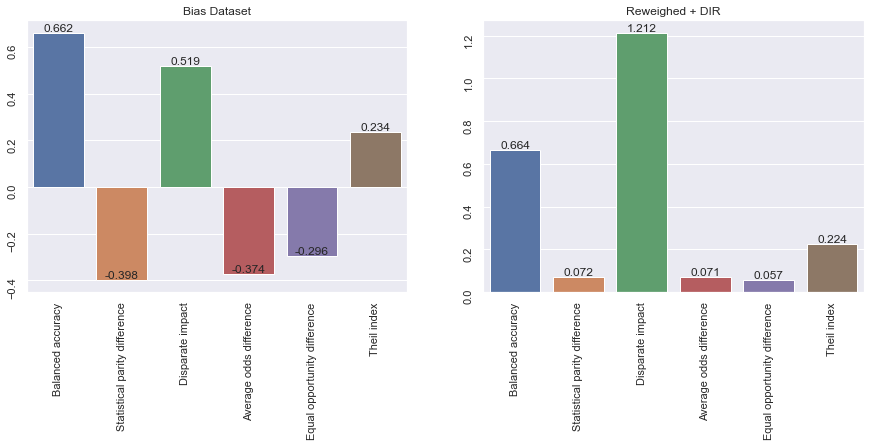

In [51]:
plot_metrics_comparison(class_metrics, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR')
plt.show()

## Algorithms Comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.3742,0.6617,0.5188,-0.2960,-0.3976,0.2336
Disparate Impact Remover,0.0693,0.6606,1.3304,0.0593,0.1046,0.2246
Reweighing,-0.0860,0.6561,0.8118,-0.0644,-0.1346,0.2066
Reweighing + DIR,0.0712,0.6636,1.2121,0.0574,0.0716,0.2239
Sampling,0.0265,0.6549,0.9712,0.0467,-0.0175,0.2416


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


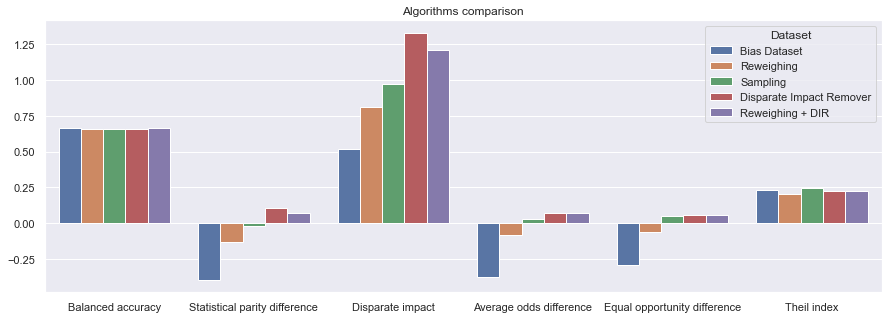

In [52]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighing': rw_class,
    'Sampling': sampled_metrics,
    'Disparate Impact Remover': dir_class,
    'Reweighing + DIR': rw_dir_score
}), 'Algorithms comparison')
plt.show()